In [148]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt

In [154]:
ratings = pd.read_csv("data/svd.csv", header=None)

In [155]:
row_index = pd.MultiIndex.from_tuples([
    ("comedy", 'Dasha'), ("comedy", 'Oleg'),
    ("comedy", 'Alex'), ("drama", 'Kate'),
    ("drama", 'Natasha'), ("drama", 'Maria')
], names=['favorite genre', 'name'])

col_index = pd.MultiIndex.from_tuples([
    ("comedy", 'film 1'), ("comedy", 'film 2'),
    ("drama", 'film 3'), ("drama", 'film 4'),
    ("drama", 'film 5')
], names=['favorite genre', 'name'])

In [156]:
ratings.index = row_index
ratings.columns = col_index

In [157]:
ratings = ratings.drop([("drama", "Natasha")]).drop(("drama", "film 3"), axis=1)

Это первая статья из небольшого цикла про рекоммендательные системы. Она будет посвящена сингулярному матричному разложению — чрезвычайно полезному алгоритму, описанному ещё в начале прошлого века, но до сих пор являющемуся основой многих рекоммендательных систем. [Евгений Фролов](https://www.eigentheories.com/), создатель пакета для построения рекоммендательных систем [Polara](https://github.com/Evfro/polara/), считает, что SVD и его модификации до сих пор способны конкурировать с намного более поздними алгоритмами [1](https://www.skoltech.ru/app/data/uploads/2018/09/Frolov_Dissertation_Final1.pdf).

Итак, чем же так полезно сингулярное матричное разложение. Как видно из названия, данный алгоритм, как многие другие алгоритмы матричного разложения, раскладывает некоторую матрицу X на произведение нескольких матриц (в данном случае трёх), причем получившиеся матрицы обладают набором интересныхх свойств, самым интересным из которых является способность извлекать из данных скрытые в них факторы, что помогает снизить размерность данных и уменьшить из зашумлённость. К тому же SVD тесно связано с другими техниками, такими как латентно семантический анализ (LSA) (George W Furnas et al. “Information retrieval using a singular value decomposition model of latentsemantic structure”. In: Proc. 11th Annu. Int. ACM SIGIR Conf. Res. Dev. Inf. Retr. ACM. 1988, pp. 465–480.) и анализ главных компонент (PCA) https://arxiv.org/abs/1404.1100.

Предположим, у нас есть набор данных, совершенно типичный для многих рекоммендательных систем — матрица пользовательских оценкок, например, фильмов размера $m\times n$, где $m$ — количество пользователей, а $n$ — количество фильмов. Для простоты предположим, что пользователей всего 5, а фильмов 4. В реальности эта матрица будет, конечно же, намного больше по размеру намного более разреженная, т.е. содержащая большое количество пропущенных значений, ведь средний пользователь смотрит просматривает от силы несколько десятком, максимум сотен из многих тысяч фильмов.

Также заметим, что в нашем примере фильмы относятся к одному из двух жанров — комедии или драмме, и пользователи в целом предпочитают один из этих жанров, что выражается в из оценках по десятибалльной шкале. Последнее замечание пока несущественно, но оно сыграет свою роль в будущем.

In [158]:
ratings

favorite genre       comedy         drama       
name                 film 1 film 2 film 4 film 5
favorite genre name                             
comedy         Dasha      7      8      1      4
               Oleg       8     10      1      2
               Alex       9     10      0      1
drama          Kate       3      1     10     10
               Maria      2      1      7     10

Давайте посмотрим, что получится, если разложить эту матрицу. Для этого используем функцию `svd` из пакета numpy:

In [172]:
from numpy.linalg import svd

U, Σ, V_t = svd(ratings)
U, Σ, V_t = U.round(2), Σ.round(2), V_t.round(2)

In [173]:
U@U.T

array([[ 1.0102e+00, -2.0000e-03,  2.0000e-03,  1.4000e-03,  6.2000e-03],
       [-2.0000e-03,  9.9610e-01,  1.0000e-03, -8.5000e-03,  4.5000e-03],
       [ 2.0000e-03,  1.0000e-03,  9.9820e-01,  3.6000e-03, -2.0000e-03],
       [ 1.4000e-03, -8.5000e-03,  3.6000e-03,  9.9980e-01,  5.1000e-03],
       [ 6.2000e-03,  4.5000e-03, -2.0000e-03,  5.1000e-03,  9.9760e-01]])

In [174]:
Σ

array([23.87, 16.44,  2.06,  0.66])

In [175]:
V_t

array([[-0.56, -0.59, -0.33, -0.47],
       [-0.3 , -0.49,  0.57,  0.59],
       [ 0.2 , -0.07,  0.72, -0.66],
       [-0.74,  0.63,  0.21, -0.06]])

Мы видим три матрицы. Первая матрица $U$ размера $m\times m$ состоит из левых сингулярных векторов и является *ортогональной*, третья, $V_t$, размером $n\times n$ тоже *ортогональна* и состоит из правых *сингулярных векторов*, а на средней диагонали средней матрицы $\Sigma$ лежат *сингулярные числа*, а остальная область заполнена 0, т.е. она единична (numpy по этому поводу сразу возвращает вектор значений, лежащих на главной диагонали, а вообще она размера $m\times n$).

Пора немного углубиться в терминологию. Ортогональность матрицы означает, что при умножении данной матрицы на саму себя транспонированную (перевернутую на правый бок) получится единичная матрица, т.е. матрица элементы главной диагонали которой равны единице. Это несложно проверить:

In [177]:
(U @ U.T).round()

array([[ 1., -0.,  0.,  0.,  0.],
       [-0.,  1.,  0., -0.,  0.],
       [ 0.,  0.,  1.,  0., -0.],
       [ 0., -0.,  0.,  1.,  0.],
       [ 0.,  0., -0.,  0.,  1.]])

In [138]:
pd.DataFrame(vh)

,0,1,2,3
0,-0.564601,-0.593711,-0.326940,-0.471002
1,-0.303452,-0.489920,0.570012,0.585646
2,0.199418,-0.066906,0.723823,-0.657143
3,-0.741198,0.634830,0.210420,-0.057789


In [139]:
from numpy.linalg import eig

In [140]:
eigenvalues, eigenvectors = eig(df.values @ df.values.T)

In [147]:
eigenvalues

array([5.69999629e+02, 2.70335562e+02, 4.23328035e+00, 5.63857000e-16,
       4.31528746e-01])

In [146]:
eigenvectors

array([[-0.45708889, -0.19042413,  0.50744576,  0.67664705,  0.19863527],
       [-0.49101683, -0.3397126 , -0.16322053, -0.07539243, -0.78177545],
       [-0.48124323, -0.4284561 , -0.22773484, -0.44481533,  0.57888383],
       [-0.43003485,  0.61770926, -0.58233602,  0.29214566,  0.09508402],
       [-0.36530426,  0.53216036,  0.56998198, -0.50324446, -0.0722752 ]])

In [95]:
pd.DataFrame(v)

,0,1,2,3,4
0,-0.338913+0.000000j,-0.168906+0.000000j,-0.223858-0.386775j,-0.223858+0.386775j,-0.160386+0.000000j
1,-0.308747+0.000000j,-0.213564+0.000000j,0.065031+0.339992j,0.065031-0.339992j,0.023883+0.000000j
2,-0.313157+0.000000j,-0.528594+0.000000j,0.160486+0.159290j,0.160486-0.159290j,-0.713185+0.000000j
3,-0.639720+0.000000j,0.677034+0.000000j,-0.573473+0.000000j,-0.573473-0.000000j,0.631193+0.000000j
4,-0.531512+0.000000j,0.433676+0.000000j,0.526366-0.152996j,0.526366+0.152996j,0.258203+0.000000j


Классический пример применения SVD – шумоподавление, например, в изображениях. Рассмотрим (чёрно-белое) изображение как матрицу $X$ размера $N\times M$, элементы которой – интенсивности каждого пикселя. Теперь попробуем выбрать $f$ столбцов пикселей из изображения, счесть их «репрезентативными» и представить каждый из оставшихся столбцов в виде линейной комбинации этих. В результате, когда вы найдёте оптимальные представления каждого столбца, получится, что вы представили исходную матрицу в виде произведения $X=AY$ матриц размера $N\times f$ и $f\times M$, то есть как раз приблизили матрицу $X$ матрицей малого ранга $f$.

* [Рекомендательные системы: SVD, часть I](https://habr.com/ru/company/surfingbird/blog/139863/)
* [Singular Value Decomposition Example In Python](https://towardsdatascience.com/singular-value-decomposition-example-in-python-dab2507d85a0)

In [73]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
result = svd.fit_transform(df)
print(result)

[[ 8.75636863  7.46819162]
 [ 7.69746219 10.35987123]
 [ 8.51756731 10.70924868]
 [15.49979129 -5.50119327]
 [13.25363904 -5.7064877 ]
 [14.25339633 -5.29394012]]


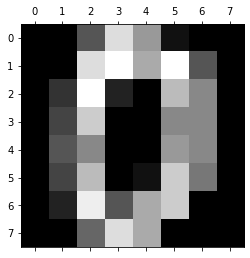

In [78]:
X, y = load_digits(return_X_y=True)
image = X[0]
image = image.reshape((8, 8))
plt.matshow(image, cmap = 'gray')

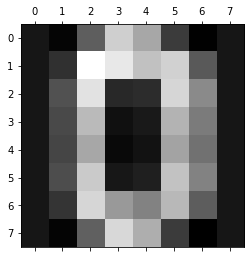

In [83]:
U, s, V = np.linalg.svd(image)
S = np.zeros((image.shape[0], image.shape[1]))
S[:image.shape[0], :image.shape[0]] = np.diag(s)
n_component = 2
S = S[:, :n_component]
V = V[:n_component, :]
A = U.dot(S.dot(V))
plt.matshow(A, cmap = 'gray')